## Load Data

In [1]:
import tensorflow as tf
import numpy as np
import transformers
import datasets
from datasets import DatasetDict

In [2]:
from datasets import load_dataset 

nsmc = datasets.load_dataset("nsmc")

Using custom data configuration default
Reusing dataset nsmc (/aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
print(nsmc)

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})


In [4]:
# 내용 확인
example = nsmc['train']
cols = example.column_names

for i in range(5):
    for col in cols:
        print(col, ":", example[col][i])
    print('\n')

id : 9976970
document : 아 더빙.. 진짜 짜증나네요 목소리
label : 0


id : 3819312
document : 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
label : 1


id : 10265843
document : 너무재밓었다그래서보는것을추천한다
label : 0


id : 9045019
document : 교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
label : 0


id : 6483659
document : 사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다
label : 1




## 2. Tokenizer

In [5]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# 모델과 토크나이저 로딩
model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base", num_labels=2)
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

In [6]:
def transform(data):
    return tokenizer(
        data['document'],
        truncation = True,
        padding = 'max_length',
        return_token_type_ids = False,
        )

In [7]:
nsmc_dataset = nsmc.map(transform, batched=True)

# 훈련 데이터셋의 1/3 선택
train_dataset = nsmc_dataset['train'].shuffle(seed=42).select(range(len(nsmc['train']) // 3))

# train, val, test 분리
split_datasets = train_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_datasets['train']
val_dataset = split_datasets['test']
test_dataset = nsmc_dataset['test']


  0%|          | 0/150 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

In [8]:
print(test_dataset)

Dataset({
    features: ['attention_mask', 'document', 'id', 'input_ids', 'label'],
    num_rows: 50000
})


## 3. Model

In [8]:
import os
from transformers import Trainer, TrainingArguments

output_dir = os.getenv('HOME')+'/aiffel/hf_save'

training_arguments = TrainingArguments(
    output_dir,                                         # output이 저장될 경로
    evaluation_strategy="epoch",           #evaluation하는 빈도
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 16,   # 각 device 당 batch size
    per_device_eval_batch_size = 16,    # evaluation 시에 batch size
    num_train_epochs = 3,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
)

In [9]:
from datasets import load_metric
metric = load_metric('accuracy')

def compute_metrics(eval_pred):    
    predictions,labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references = labels)

In [10]:
trainer = Trainer(
    model=model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=train_dataset,    # training dataset
    eval_dataset=val_dataset,       # evaluation dataset
    compute_metrics=compute_metrics,
)

In [12]:
trainer.train()

/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.275100,0.289651,0.887900
2,0.190900,0.328153,0.895300
3,0.118300,0.456156,0.891900


TrainOutput(global_step=7500, training_loss=0.21203673909505208, metrics={'train_runtime': 12126.1369, 'train_samples_per_second': 9.896, 'train_steps_per_second': 0.618, 'total_flos': 3.15733266432e+16, 'train_loss': 0.21203673909505208, 'epoch': 3.0})

In [14]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.45857465267181396,
 'eval_accuracy': 0.89024,
 'eval_runtime': 1710.6781,
 'eval_samples_per_second': 29.228,
 'eval_steps_per_second': 1.827,
 'epoch': 3.0}

## 4. Fine-tuning

- 데이터 전처리
- Bucketing
- warmup_steps

In [11]:
import re

def preprocess_sentences(sentences):
    processed_sentences = []
    
    for sentence in sentences['document']:  # 배치에서 문장을 순회
        # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
        sentence = sentence.lower().strip()
    
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence)
    
        # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체
        sentence = re.sub(r"[^a-zA-Z0-9ㄱ-ㅎㅏ-ㅣ가-힣.,?!]+", " ", sentence)
        sentence = sentence.strip()
        
        processed_sentences.append(sentence)
    
    return {'document': processed_sentences} 

In [12]:
nsmc_dataset = nsmc.map(preprocess_sentences, batched=True)
nsmc_dataset = nsmc.map(transform, batched=True)

# 훈련 데이터셋의 1/3 선택
train_dataset = nsmc_dataset['train'].shuffle(seed=42).select(range(len(nsmc['train']) // 3))

# train, val, test 분리
split_datasets = train_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_datasets['train']
val_dataset = split_datasets['test']
test_dataset = nsmc_dataset['test']


  0%|          | 0/150 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

  0%|          | 0/150 [00:00<?, ?ba/s]

Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-29f0bf981878da20.arrow


In [13]:
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification, AutoTokenizer
from transformers import get_linear_schedule_with_warmup

training_arguments = TrainingArguments(
    output_dir,                                         # output이 저장될 경로
    evaluation_strategy="epoch",           #evaluation하는 빈도
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 8,   # 각 device 당 batch size
    per_device_eval_batch_size = 8,    # evaluation 시에 batch size
    num_train_epochs = 5,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
    warmup_steps=500,                                 # 웜업 스텝 수
)


trainer = Trainer(
    model=model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=train_dataset,    # training dataset
    eval_dataset=val_dataset,       # evaluation dataset
    compute_metrics=compute_metrics,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


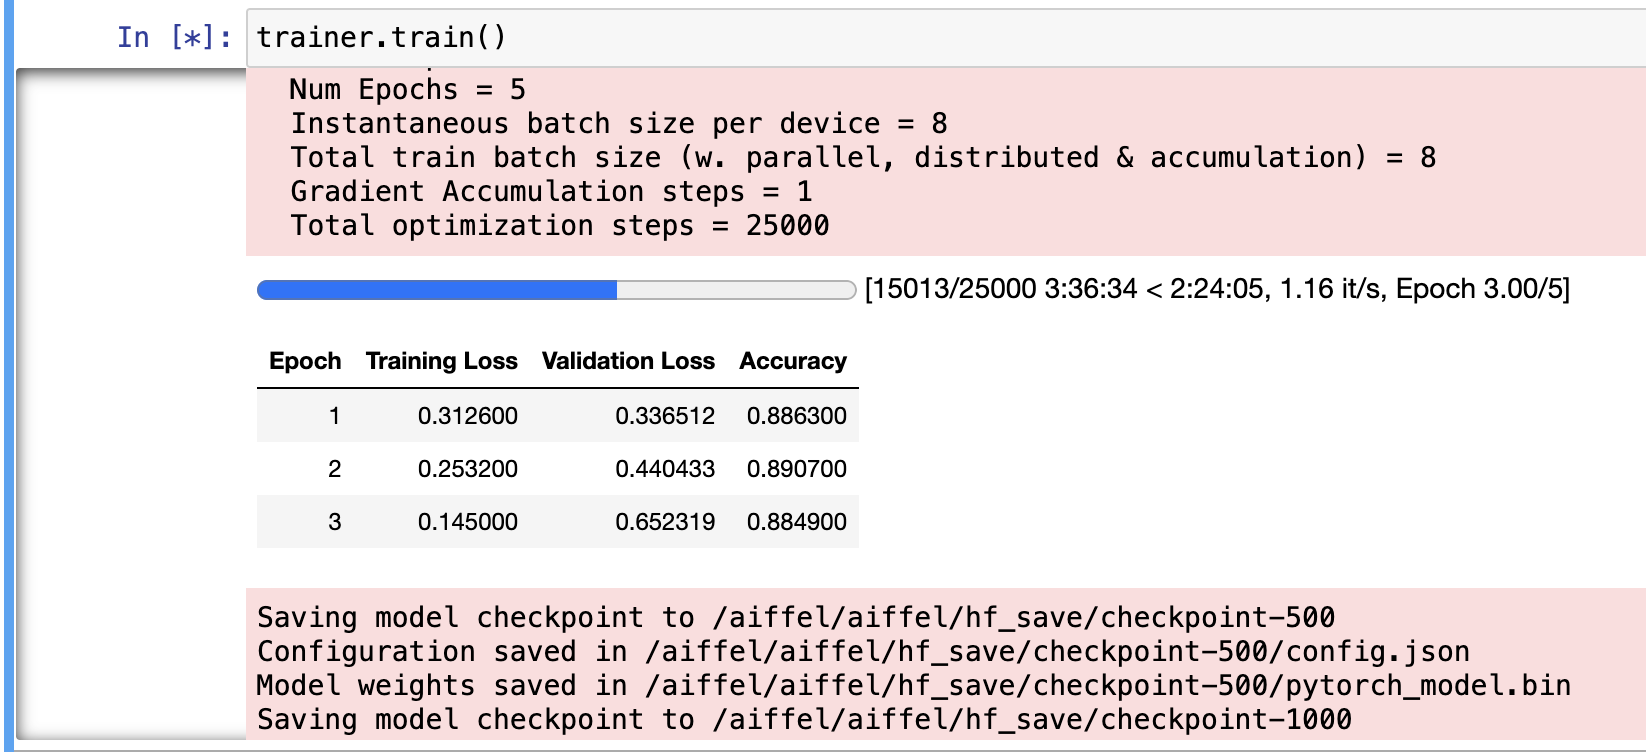

In [21]:
# 저장된 모델 load
checkpoint_path = "/aiffel/aiffel/hf_save/checkpoint-500"

# Load the model from the saved checkpoint
# The path is specified directly without the 'file://' prefix.
model = AutoModelForSequenceClassification.from_pretrained(checkpoint_path)

# Load the tokenizer from the same checkpoint
tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)

loading configuration file /aiffel/aiffel/hf_save/checkpoint-500/config.json
Model config BertConfig {
  "_name_or_path": "klue/bert-base",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}

loading weights file /aiffel/aiffel/hf_save/checkpoint-500/pytorch_model.bin
All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassific

OSError: Can't load tokenizer for '/aiffel/aiffel/hf_save/checkpoint-500'. Make sure that:

- '/aiffel/aiffel/hf_save/checkpoint-500' is a correct model identifier listed on 'https://huggingface.co/models'

- or '/aiffel/aiffel/hf_save/checkpoint-500' is the correct path to a directory containing relevant tokenizer files



In [22]:
training_arguments = TrainingArguments(
    output_dir,                                         # output이 저장될 경로
    evaluation_strategy="epoch",           #evaluation하는 빈도
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 8,   # 각 device 당 batch size
    per_device_eval_batch_size = 8,    # evaluation 시에 batch size
    num_train_epochs = 5,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
    warmup_steps=500,                                 # 웜업 스텝 수
)


trainer = Trainer(
    model=model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=train_dataset,    # training dataset
    eval_dataset=val_dataset,       # evaluation dataset
    compute_metrics=compute_metrics,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [23]:
trainer.evaluate(test_dataset)

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.
***** Running Evaluation *****
  Num examples = 50000
  Batch size = 8


{'eval_loss': 0.38007479906082153,
 'eval_accuracy': 0.846,
 'eval_runtime': 1610.3264,
 'eval_samples_per_second': 31.05,
 'eval_steps_per_second': 3.881}

## 회고

이미 학습된 모델을 간편하게 사용하고 기본적으로 높은 성능을 확인할 수 있었다.

150000개 데이터를 학습시키는데 9시간이 발생해 batch size를 늘려보려 했지만 자원 문제로 늘릴 수 없었고
데이터의 사이즈를 1/3로 줄여 학습했다.

fine tuning 시 데이터 전처리 후 하이퍼파라미터를 다양하게 변경해보았으나
오히려 성능이 줄어들고 동일하게 과적합으로 인해 loss가 증가하여 baseline보다 성능이 좋아지지 않았다.

데이터 수를 줄이고 bucketing을 적용하니 학습 시간이 빨라졌지만 한번 돌릴때마다 학습 시간이 3시간 이상 소요되어
다양한 시도를 하기에 어려움이 있었다.

LLM모델의 과적합을 해결하는 방법을 더 찾아봐야 할 것 같다.